Сделан первичный анализ и собранно немного статистике.  
Также сделана попытка реализовать обсчет разницы во времени м/д операциями с привязкой к конкретному вагону и станций.  

__долго рисует графики__


# Introduction

__Поставленна следующая задача__  

1. Проанализировать продолжительность технологических операций по станциям погрузки-выгрузки (в цепочках от операции исключения из поезда  до операции включения в поезда, где есть операция погрузки или выгрузке между ними). Необходимо ответить на вопрос, возможно ли по имеющимся статданным, сделать прогноз включения в поезда вновь отправленных вагонов на период 36 часов, данным методом (просчитывая «судьбы» вагонов по техпроцессам). На этот вопрос можно ответить и количественно: насколько возможно? - то есть, каков разброс продолжительности технологических операций поступающих под погрузку-выгрузку вагонов и какова степерь неопределенности (или до какой степени можно установить определенность) самого техпроцесса интересующих нас вагонов в данном временном горизонте? Требуется как можно более  полно ответить на данные вопросы (в этом есть вызов, совершенного результата в наших рамках вряд ли можно достичь), результаты можно представить в таблицах, графиках, рисунках. Можно ограничиться несколькими станциями для исследования.
2. Собственно прогнозирование с учетом результатов п. 1. Опять же, можно ограничиться несколькими станциями, но по возможности  необходимо использовать такой подход, который мог бы быть использован для тысяч станций.

Начните с п. 1, рекомендации для п. 2 будут еще даны.  
Полотняный завод (xlsx) — это сведенная мной стата по техпроцессу погужаемых и выгружаемых вагонов по одной станции. И в доке как я ее сводил делал, это по старым данным. При желании с тоже можно рабоать, чтобы какие-то может дополнительные интересые выводы нарыть.

In [1]:
# установка стороних библиотек
#!pip install graphviz

# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime


# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
default_c = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
default_c = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns


# setting parameters for graphs
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

In [2]:
'''Функция для получения информаций о столбце'''
def column_info(column):
    print('Количество NaN в столбце:', (column.isnull()).sum(), '\n')
    print('Соотношение непустых/пустых значений в столбце:' '\n', column.isnull(
                                    ).value_counts(normalize=True)*100, '\n')
    print('Уникальные значения:', column.nunique(), '\n')
    print('Количество повторений значения: \n', column.value_counts(), '\n')    
    return

'''Визуализация бинарных и категориальных параметров датасета и их значений'''
# value_display - количество значений для отображения, 0 - отображаем все значения
def visualization(column, value_display=0, sort_by_index=True):
    #  проверка количества значений
    if value_display > 0:
        # подсчет и формирование переменных и их значений для отображения
        col_values = column.value_counts().nlargest(
                                    value_display).sort_values()
    else:
        col_values = column.value_counts()
        
    if sort_by_index: 
        col_values = col_values.sort_index()
    # формирование графика переменных
    ax = col_values.plot(kind='bar', color='g', alpha=0.4)
    # установка и отображение значений для сформированных переменных
    for i, v in enumerate(col_values):
        plt.text(i, v+(col_values.max()/100), 
        ""+str(v), ha='center', fontsize='xx-large')
    
    plt.xticks(rotation=0)
    # отрисовка сформированной информаций
    plt.show()

'Функция для получения информаций о столбце'

'Визуализация бинарных и категориальных параметров датасета и их значений'

car_number - Номер вагона	
operation_st_id - ID станции операции	
operation_st_esr - ЕСР станции операции	 
operation_date - Дата операции	 
operation_car - Код операции ВМ  АСОУП	 
operation_train	 - Код операции ПМ  АСОУП	 
park - Парк	  
track - Путь	  
loaded - Признак груженого вагона (1 -  груженый, 2- порожний)    
train_id	 - ID поезда	  
index_train - Индекс поезда	  
number_train - Номер поезда	  
rod_train - Род поезда АСОУП	  
weight_brutto - Вес поезда брутто	  
weight_netto - Вес поездa нетто	  
destination_id - id станции назначения вагона	  
destination_esr	 - ЕСР станции назначения вагона 	  
stkgos_id - Код межгосударственного стыка передачи вагона	   
gruz - Код груза 	  
danger - Признак опасного груза в вагоне ( 1 - в вагоне опасный груз,  null  - иначе)    
group_car - Номер рефрижераторной  секции (номер накладной у вагонов оной реф. секции м.б. разный)  
kod_ group - Код группы вагонов (1 - признак рефрижераторной секции, 2 - признак кольцевого маршрута, 3 - вагон в сцепе, 4 - групповая отправка, 5 - прямой маршрут)  
weight - Вес груза(кг)	  
sender - ОКПО грузоотправителя	  
receiver - ОКПО грузополучателя	  
length - Длина вагона	  
tare_weight - Вес тары вагона  (ц)	   
rodvag - Род вагона АСОУП  (учетного)	   
operator - ОКПО управляющей организации	(Код ОКПО собственника для собственника вагона, Код ОКПО арендатора для инвентарного вагона, сданного в аренду)   
innovag	 - Признак инновационности вагона (1 - вагон инновационный, null - иначе)     
adm - Код АСОУП администрации-собственника вагона  	
lves - Признак легковесного вагона	  
UNS - Уникальный номер события (операции)	   
KDS - Код сообщения, породившего запись с данной операцией	    
SSP_station_esr - ЕСР станция ССП	   
SSP_station_id - id станции ССП	   
int_disl - Вид внутристанционной дислокации (0 – другое, 1 - подъездной путь, 2 - грузовой фронт, 3 - контейнерная площадка, 4 - пути ВРП, 5 - пути ППВ, 6 - пути ППС, 7 - пути ЛРЗ, 8 - пути отстоя)  
following_mark - Признак следования вагона	(0 - без информации, 1 - вагон следует на промывку/пропарку, 2 - вагон следует на хранение, 3 - вагон следует на промывку и хранение)  
processing_road - Код дороги расчета	   
special_mark_1 - Особая отметка 1 (1 - "груз на своих осях", 2 - принадлежность вагона к маршруту, 3-5 - группа вагонов, оформленных одной накладной, 6 – оформлены  разными накладными но одной грузовой  таможенной  декларацией, 7-8 - сцеп вагонов, расцепка которых запрещена, или  транспортер сцепного типа, 9 - вагон нерабочего парка (неисправные, для спецтех надобностей или остальных нужд)     
dispatch_id - Идентификатор  отправки	   
junction - Прогнозный стык сдачи  поезда    

в цепочках от операции исключения из поезда  до операции включения в поезда, где есть операция погрузки или выгрузке между ними - operation_car - 3	(Исключение из поезда	ИСКЛЮЧЕНИЕ ИЗ ПОЕЗДА	ИСКП) - 4 (Включение в поезд	ВКЛЮЧЕНИЕ В ПОЕЗД	ВКЛП)

In [3]:
# загрузим данные
# датасет обучения и проверки
df = pd.read_csv('statistics-07-20.csv', sep=';')

In [4]:
df

,index_train,length,car_number,destination_esr,adm,danger,gruz,loaded,operation_car,operation_date,operation_st_esr,operation_st_id,operation_train,receiver,rodvag,rod_train,sender,ssp_station_esr,ssp_station_id,tare_weight,weight_brutto
0,NaN,NaN,62827035,984700.0,NaN,NaN,NaN,2.0,81.0,2020-07-16 03:40:00,984502.0,2.000039e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,62827035,862201.0,20.0,NaN,421034.0,NaN,18.0,2020-07-16 14:10:00,984700.0,2.002026e+09,NaN,93149858.0,60.0,NaN,68398528.0,NaN,NaN,249.0,NaN
2,NaN,NaN,62827316,863007.0,NaN,NaN,NaN,2.0,80.0,2020-07-16 14:50:00,863007.0,2.001933e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,62827381,862108.0,NaN,NaN,NaN,2.0,80.0,2020-07-16 14:16:00,862108.0,2.001931e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,62845730,887904.0,20.0,NaN,421034.0,NaN,19.0,2020-07-16 15:15:00,967808.0,2.000039e+09,NaN,81195103.0,60.0,NaN,52682351.0,NaN,NaN,248.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189910,8.600099e+14,1.0,62827548,76404.0,NaN,NaN,161185.0,1.0,4.0,2020-07-16 03:29:00,860009.0,2.001933e+09,5.0,39513543.0,60.0,10.0,76900054.0,860009.0,2.001933e+09,NaN,6256.0
4189911,8.600099e+14,1.0,62827548,76404.0,NaN,NaN,161185.0,1.0,4.0,2020-07-16 03:30:00,860009.0,2.001933e+09,5.0,39513543.0,60.0,10.0,76900054.0,860009.0,2.001933e+09,NaN,6256.0
4189912,8.302009e+14,NaN,62827910,862201.0,NaN,NaN,NaN,2.0,3.0,2020-07-15 20:00:00,862201.0,2.001931e+09,4.0,NaN,60.0,10.0,NaN,862201.0,2.001931e+09,NaN,1756.0
4189913,NaN,NaN,62827514,968302.0,NaN,NaN,NaN,1.0,80.0,2020-07-16 02:37:00,968302.0,2.000039e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

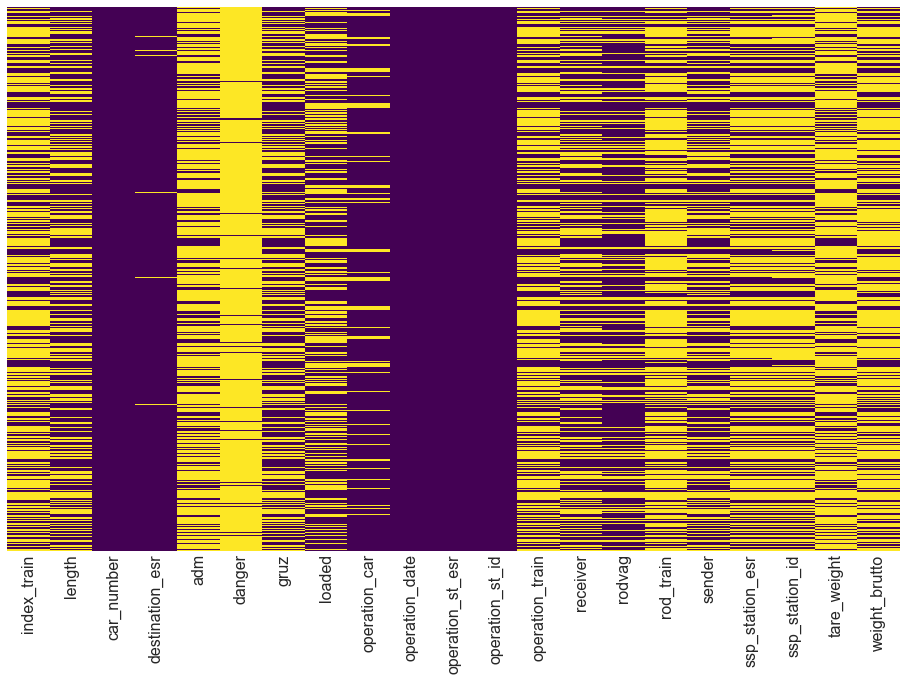

In [5]:
# визуализируем NaN
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis', cbar=False,)

In [6]:
# подсчитаем количество пропусков 
df.isnull().sum()

index_train         2222193
length              1715134
car_number                0
destination_esr       61421
adm                 3085197
danger              4077929
gruz                1779461
loaded              1645999
operation_car        541281
operation_date            0
operation_st_esr        598
operation_st_id         598
operation_train     2222194
receiver            1764323
rodvag              1117475
rod_train           2623663
sender              1764323
ssp_station_esr     2222193
ssp_station_id      2255185
tare_weight         3085197
weight_brutto       2623318
dtype: int64

In [7]:
# процентное соотношение количество пропусков 
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

index_train - 53%
length - 41%
car_number - 0%
destination_esr - 1%
adm - 74%
danger - 97%
gruz - 42%
loaded - 39%
operation_car - 13%
operation_date - 0%
operation_st_esr - 0%
operation_st_id - 0%
operation_train - 53%
receiver - 42%
rodvag - 27%
rod_train - 63%
sender - 42%
ssp_station_esr - 53%
ssp_station_id - 54%
tare_weight - 74%
weight_brutto - 63%


Как видим пропуски у нас присутствуют во всех столбцах за исключением следующих двух - car_number, operation_date. При текущей расмотрение мне не видеться возможным, как то заполнить данные пропуски. В моем понимание для первичного расмотрение поставленной задачи, количество избыточно. Рассмотрим какие столбцы стоит удалить.

In [8]:
df.columns

Index(['index_train', 'length', 'car_number', 'destination_esr', 'adm',
       'danger', 'gruz', 'loaded', 'operation_car', 'operation_date',
       'operation_st_esr', 'operation_st_id', 'operation_train', 'receiver',
       'rodvag', 'rod_train', 'sender', 'ssp_station_esr', 'ssp_station_id',
       'tare_weight', 'weight_brutto'],
      dtype='object')

На основе первичного анализа было приято решение, оставить следующие колонки.

car_number - номер вагона (так будем рассматривать "цикл жизни вагона" на станций)   
loaded - признак груженого вагона (1 - груженый, 2- порожний) (для понимания операций без зачета, что происходит с вагоном).  
operation_car - код операции ВМ АСОУП (нужно как раз спрогнозировать время м/д операциями искл (3) и вкл (4))   
operation_date - дата операции (смотрим делту времени)  
operation_st_esr - ЕСР станции операции (единая сетевая разметка - система цифрового обозначения ж/д станций)  

При дальнейшем анализе, если будет необходимо параметры будут добавляться.

In [9]:
for_analiz = ['operation_st_esr', 'car_number', 'operation_car', 'operation_date',
        'loaded']

In [10]:
data = df[for_analiz]

In [11]:
data

,operation_st_esr,car_number,operation_car,operation_date,loaded
0,984502.0,62827035,81.0,2020-07-16 03:40:00,2.0
1,984700.0,62827035,18.0,2020-07-16 14:10:00,NaN
2,863007.0,62827316,80.0,2020-07-16 14:50:00,2.0
3,862108.0,62827381,80.0,2020-07-16 14:16:00,2.0
4,967808.0,62845730,19.0,2020-07-16 15:15:00,NaN
...,...,...,...,...,...
4189910,860009.0,62827548,4.0,2020-07-16 03:29:00,1.0
4189911,860009.0,62827548,4.0,2020-07-16 03:30:00,1.0
4189912,862201.0,62827910,3.0,2020-07-15 20:00:00,2.0
4189913,968302.0,62827514,80.0,2020-07-16 02:37:00,1.0


У нас получился датафрейм на 5 столбцов и 4 189 915 строк наблюдений. Расммотрим данный датафрейм и столбцы.

In [12]:
 # размерность датасета
data.shape
# примеры из датасета
data.sample(5)
# информация о датасете
data.info()
# статистика по датасету
data.describe(include='all').T

(4189915, 5)

,operation_st_esr,car_number,operation_car,operation_date,loaded
2908908,887603.0,61286803,80.0,2020-07-02 15:30:00,2.0
2011095,926403.0,58671256,4.0,2020-07-27 00:54:00,1.0
975080,931401.0,52480738,NaN,2020-07-20 10:36:00,NaN
498036,946801.0,34118174,NaN,2020-07-18 02:00:00,NaN
4077801,970001.0,54024823,80.0,2020-07-16 06:41:00,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4189915 entries, 0 to 4189914
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   operation_st_esr  float64
 1   car_number        int64  
 2   operation_car     float64
 3   operation_date    object 
 4   loaded            float64
dtypes: float64(3), int64(1), object(1)
memory usage: 159.8+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
operation_st_esr,4189317.0,NaN,NaN,NaN,916910.64895,48946.857746,830003.0,866306.0,923301.0,967600.0,998100.0
car_number,4189915.0,NaN,NaN,NaN,60023673.494721,13942307.44113,20023164.0,53600151.0,58699844.0,63218838.0,98099997.0
operation_car,3648634.0,NaN,NaN,NaN,31.092853,33.205675,3.0,4.0,18.0,80.0,81.0
operation_date,4189915,40443,2020-07-26 10:00:00,1167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loaded,2543916.0,NaN,NaN,NaN,1.492943,0.499951,0.0,1.0,1.0,2.0,2.0


In [13]:
# посмотрим пропуски 
data.isnull().sum()

operation_st_esr        598
car_number                0
operation_car        541281
operation_date            0
loaded              1645999
dtype: int64

Пропуски по operation_st_esr возможно сможем восстановить, через сочетание car_number и operation_date.  
Пропуски в operation_car, оставим пока так. Не вижу возможности как их восстановить.  
Пропуски в loaded пока для нас не слишком критичен, оставим все как есть.

In [14]:
# посмотрим уникальные значения для каждого столбца с включением nan
data.nunique(dropna=False)

operation_st_esr       745
car_number          441248
operation_car           21
operation_date       40443
loaded                   4
dtype: int64

Как видим датафрейм охватывает 745 ж/д станций и 441 248 вагонов на них. Количество операций доступных для проведения над вагонами 21. Уникальных меток времени 40 443. Состояний вагона 4 позиций - указанны всего 2 (1 и 2), + пропуски (nan) + еще 1 неизвестная. 

# Анализ однопеременных параметров.

### operation_st_esr

In [15]:
column_info(data.operation_st_esr)

Количество NaN в столбце: 598 

Соотношение непустых/пустых значений в столбце:
 False    99.985728
True      0.014272
Name: operation_st_esr, dtype: float64 

Уникальные значения: 744 

Количество повторений значения: 
 985906.0    207099
967600.0    146427
946801.0    116936
863007.0     96307
864207.0     82794
             ...  
915907.0         1
884802.0         1
917902.0         1
911304.0         1
950900.0         1
Name: operation_st_esr, Length: 744, dtype: int64 



<AxesSubplot:xlabel='operation_st_esr', ylabel='Count'>

Text(0.5, 0, 'номера станций')

Text(0, 0.5, 'количество операций на станций')

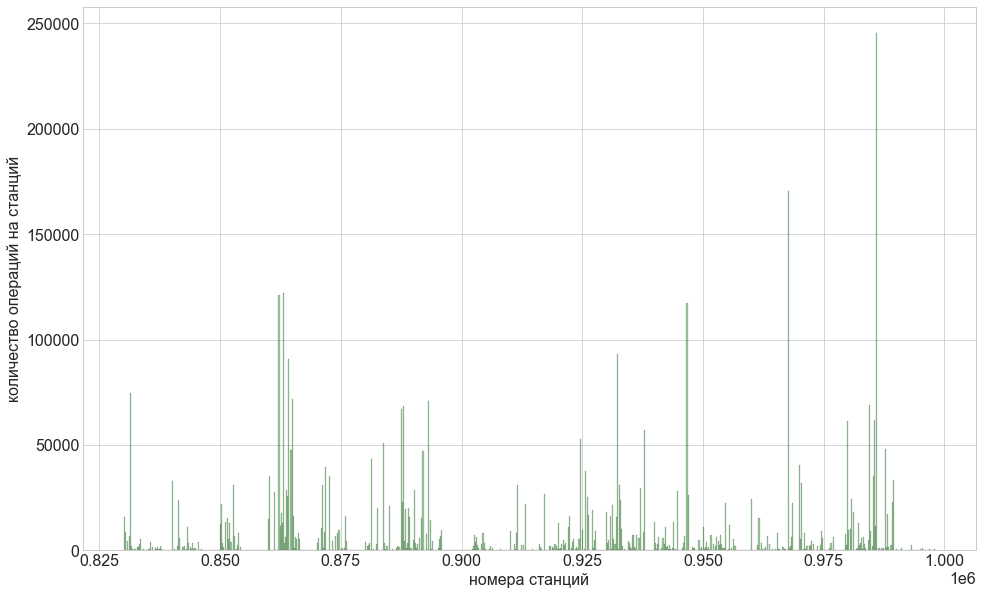

In [16]:
# График распределения
sns.histplot(data.operation_st_esr, element='bars', color='g', alpha=0.4, bins=744)
plt.xlabel('номера станций')
plt.ylabel('количество операций на станций')

Как видим здесь возможно имеет смылс ввести какую-то категоризацию станций.([см.здесь](https://docs.cntd.ru/document/902285883), "4. Специализация и классификация железнодорожных станций"), либо по количеству совершенных операций.

### car_number

In [17]:
column_info(data.car_number)

Количество NaN в столбце: 0 

Соотношение непустых/пустых значений в столбце:
 False    100.0
Name: car_number, dtype: float64 

Уникальные значения: 441248 

Количество повторений значения: 
 55864821    310
55822928    290
55927537    287
55626428    273
55701130    272
           ... 
55111876      1
37546611      1
34226019      1
34227082      1
54058367      1
Name: car_number, Length: 441248, dtype: int64 



<AxesSubplot:xlabel='car_number', ylabel='Count'>

Text(0.5, 0, 'номера вагонов')

Text(0, 0.5, 'количество упоминаний номера вагона')

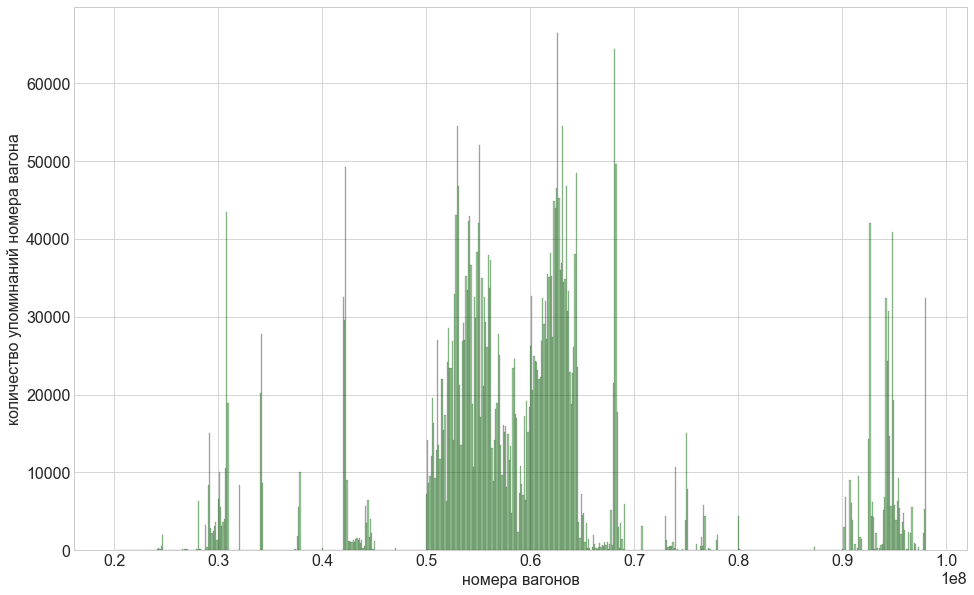

In [18]:
# График распределения
sns.histplot(data.car_number, element='bars', color='g', alpha=0.4)
plt.xlabel('номера вагонов')
plt.ylabel('количество упоминаний номера вагона')

Здесь просто по факту номер вагона, его скорее всего имеет смысл скооперировать со станцией.

### operation_car

In [19]:
column_info(data.operation_car)

Количество NaN в столбце: 541281 

Соотношение непустых/пустых значений в столбце:
 False    87.081337
True     12.918663
Name: operation_car, dtype: float64 

Уникальные значения: 20 

Количество повторений значения: 
 4.0     828782
80.0    695232
3.0     597659
81.0    343248
18.0    284385
21.0    259882
10.0    242559
11.0    105395
19.0     96998
20.0     51427
26.0     45153
78.0     42649
79.0     36346
28.0     16617
16.0       929
27.0       597
13.0       428
29.0       344
14.0         3
23.0         1
Name: operation_car, dtype: int64 



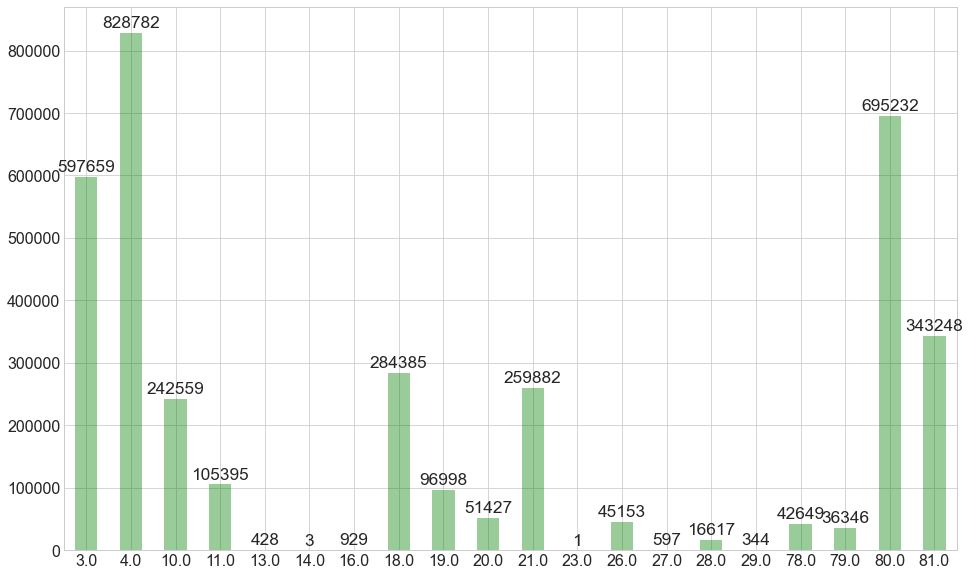

In [20]:
visualization(data.operation_car)

Здесь мы видим операций и их количество. Нас интересуют совокупность операций 3 и 4 и операций м/д ними. Мы видим, что операций включения (4.0) на 300 000 больше. Скорее всего это те вагоны по которым операций исключения (3.0) не попали в наш временной промежуток. Также у нас как видим достаточно много операций по подаче вагона на ПП(80.0).  
Также надо учитывать, что порядка 13% данного столбца это nan.

In [21]:
column_info(data.operation_date)

Количество NaN в столбце: 0 

Соотношение непустых/пустых значений в столбце:
 False    100.0
Name: operation_date, dtype: float64 

Уникальные значения: 40443 

Количество повторений значения: 
 2020-07-26 10:00:00    1167
2020-07-20 10:00:00    1147
2020-07-15 20:00:00    1064
2020-07-30 15:00:00    1029
2020-07-18 12:00:00    1010
                       ... 
2020-07-31 04:52:00       1
2020-07-30 19:45:00       1
2020-07-01 10:48:00       1
2020-07-01 08:27:00       1
2020-07-06 17:21:00       1
Name: operation_date, Length: 40443, dtype: int64 



In [22]:
# преобразуем в формат datatime
data.operation_date = pd.to_datetime(data.operation_date, 
                                                     format='%Y%m%d %H:%M:%S')

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:xlabel='operation_date', ylabel='Count'>

Text(0.5, 0, 'дата')

Text(0, 0.5, 'количество упоминаний даты')

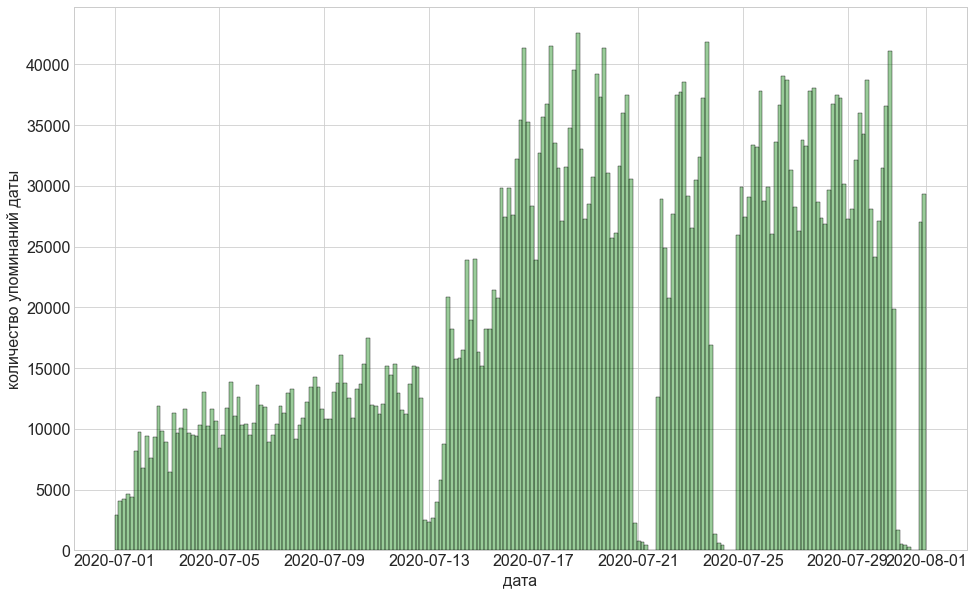

In [23]:
# График распределения
sns.histplot(data.operation_date, element='bars', color='g', alpha=0.4)
plt.xlabel('дата')
plt.ylabel('количество упоминаний даты')

In [24]:
data.operation_date.min()
data.operation_date.max()

Timestamp('2020-07-01 00:00:00')

Timestamp('2020-07-31 23:59:00')

Как мы видим, в начале месяца работы идут по нарастающей. Во второй половине месяца мы выходим на "плато" с некоторыми провалами в 20 числах и в конце месяца. Всего период охватывает 1 месяц.

Количество NaN в столбце: 1645999 

Соотношение непустых/пустых значений в столбце:
 False    60.715217
True     39.284783
Name: loaded, dtype: float64 

Уникальные значения: 3 

Количество повторений значения: 
 1.0    1289908
2.0    1254007
0.0          1
Name: loaded, dtype: int64 



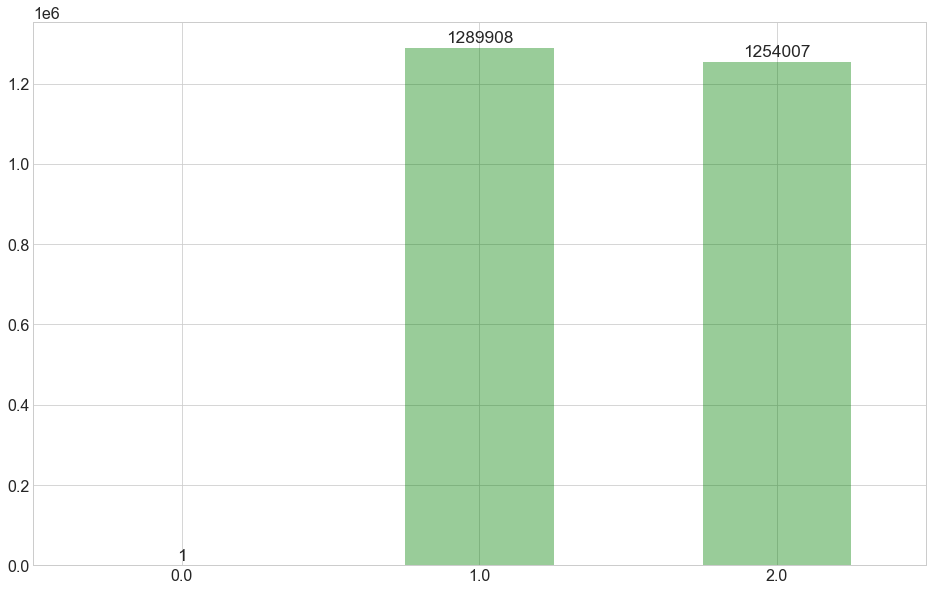

In [25]:
column_info(data.loaded)
visualization(data.loaded)

Как мы видим здесь 0.0 это у нас скорее всег офактор ошибки. И около 40% пропущенные значения. Остальные значения разделяються практически поровну.

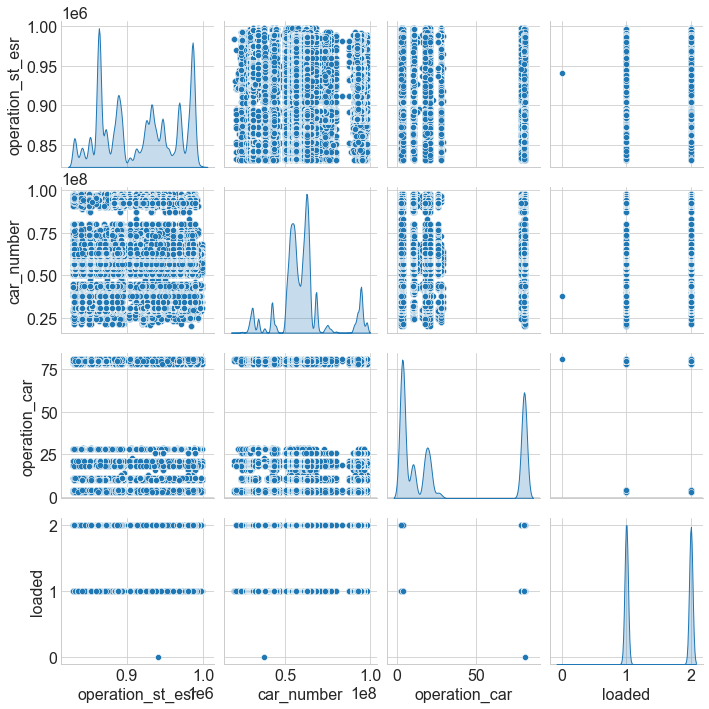

In [26]:
# посмотрим парные графики по числовым данным
sns.pairplot(data, diag_kind ='kde')

# попытка реализовать разницу времени м/д операциями

In [27]:
# список станций
station = list(data.operation_st_esr.drop_duplicates())
# список вагонов 
cargo = list(data.car_number.drop_duplicates())

In [28]:
len(station)
len(cargo)

745

441248

In [29]:
# тестовый список станций и вагонов
testst = [984502.0]
testcar = [62827035]

In [30]:
%%time
# выборка станций и вагона
for i in testst:
    data00012 = data[data.operation_st_esr == i]
    for j in testcar:
        data00012 = data00012[data00012.car_number == j]
        
data00012

CPU times: user 30.4 ms, sys: 3.23 ms, total: 33.6 ms
Wall time: 14.8 ms


,operation_st_esr,car_number,operation_car,operation_date,loaded
0,984502.0,62827035,81.0,2020-07-16 03:40:00,2.0
175727,984502.0,62827035,4.0,2020-07-17 14:20:00,2.0
3805045,984502.0,62827035,3.0,2020-07-14 08:36:00,1.0
3805052,984502.0,62827035,80.0,2020-07-14 11:55:00,1.0
3988705,984502.0,62827035,21.0,2020-07-15 05:36:00,NaN


In [31]:
# с помощью функций подсчитываем разницу в созданной таблице
data00012['diff'] = data00012.operation_date.diff()

In [32]:
# реализация - в столбце diff видим время, это время после предыдущей операций
data00012

,operation_st_esr,car_number,operation_car,operation_date,loaded,diff
0,984502.0,62827035,81.0,2020-07-16 03:40:00,2.0,NaT
175727,984502.0,62827035,4.0,2020-07-17 14:20:00,2.0,1 days 10:40:00
3805045,984502.0,62827035,3.0,2020-07-14 08:36:00,1.0,-4 days +18:16:00
3805052,984502.0,62827035,80.0,2020-07-14 11:55:00,1.0,0 days 03:19:00
3988705,984502.0,62827035,21.0,2020-07-15 05:36:00,NaN,0 days 17:41:00
